# PyMC 403: Introduction to Causal Inference with PPLs

Causal inference asks a deceptively simple question: "What would have happened if things were different?" Whether we're evaluating a job training program, testing a new medical treatment, or analyzing the impact of a policy change, we want to understand the causal effect of an intervention not just observe correlations in the data.

Traditional statistical methods often struggle with causal questions because they conflate correlation with causation. When confounders variables that affect both treatment assignment and outcomes are present, naive comparisons can lead us astray. This notebook demonstrates how probabilistic programming languages (PPLs) provide a powerful framework for causal inference that makes confounding explicit, quantifies uncertainty properly, and enables us to answer counterfactual questions directly.

## Why Probabilistic Programming Languages?

Probabilistic Programming Languages (PPLs) like NumPyro, PyMC, and Stan offer several compelling advantages for causal inference:

1. **Express causal models naturally**: We can explicitly model both the treatment assignment mechanism and the outcome process, making confounding relationships transparent in our code. This aligns perfectly with Pearl's structural causal models and the backdoor criterion.

2. **Quantify uncertainty rigorously**: Bayesian inference gives us full posterior distributions, not just point estimates. We get credible intervals that properly account for all sources of uncertainty, from parameter estimation to model specification.

3. **Implement the `do` operator directly**: PPLs let us implement Pearl's do-calculus naturally, allowing us to compute counterfactuals ("what if everyone received treatment?") by simply conditioning on interventions rather than observations.

4. **Flexible modeling without sacrificing interpretability**: We can use non-linear models, hierarchical structures, and other sophisticated approaches while maintaining clear causal interpretability. The same framework works for simple linear models and complex hierarchical designs.

## The Lalonde Dataset

We'll work with the famous [Lalonde dataset](https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html) which studies the effect of a job training program on earnings. This dataset is a classic in causal inference because it vividly demonstrates how naive comparisons can be misleading when confounders are present. The treated and control groups differ systematically in pre-treatment characteristics (age, education, prior earnings, etc.), making a simple comparison of means unreliable. By properly adjusting for these confounders, we can uncover the true causal effect of the training program.

**Reference**: Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc.model.transform.conditioning import do, observe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## Read and Preprocess Data

In [2]:
data_path = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(data_path)

# Convert the data to the right format
data["re75"] = data["re75"] / 1_000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1_000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = [
    "education",
    "age",
    "re75",
    "black",
    "hispanic",
    "married",
    "nodegree",
]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]
n_obs = df.shape[0]
df.head()

,treat,education,age,re75,black,hispanic,married,nodegree,re78
0,1,11,37,0.0,1,0,1,1,9.930047
1,1,9,22,0.0,0,1,0,1,3.595895
2,1,12,30,0.0,1,0,0,0,24.909451
3,1,11,27,0.0,1,0,0,1,7.506147
4,1,8,33,0.0,1,0,0,1,0.289791


## Causal DAG

Before building our models, we need to establish a clear understanding of the causal relationships in the data. We have the following structure:

- **Treatment variable** (`treat`): The intervention we're studying (job training program)
- **Outcome variable** (`re78`): What we want to measure the effect on (earnings in 1978)
- **Covariates**: Pre-treatment variables that might confound the relationship

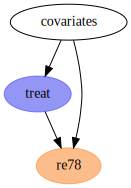

In [3]:
dag = gr.Digraph()
dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")
dag.node("covariates")
dag.edge("treat", "re78")
dag.edge("covariates", "treat")
dag.edge("covariates", "re78")
dag

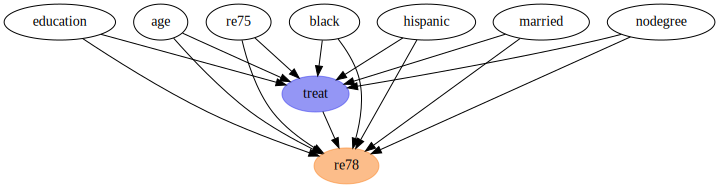

In [4]:
# Here's the concrete structure with all covariates shown:
dag = gr.Digraph()
dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")
dag.edge("treat", "re78")
for covariate in covariates_names:
    dag.edge(covariate, "treat")
    dag.edge(covariate, "re78")
dag

## Exploratory Data Analysis

In [ ]:
g = sns.pairplot(
    df[["treat", "education", "age", "re75", "re78"]],
    hue="treat",
    diag_kind="hist"
)
g.figure.suptitle(
    "Numerical Features Pairplot",
    fontsize=18,
    fontweight="bold",
    y=1.03
);

In [ ]:
# Evaluate what our answer would be if we just naively predicted the average earnings
# of treated and untreated individuals, without accounting for the
# potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]
naive_prediction = (
    treated_individuals["re78"].mean() - untreated_individuals["re78"].mean()
)
naive_prediction

### The Confounding Problem

The naive estimate simply compares average earnings between treated and untreated groups. However, if these groups differ systematically in pre-treatment characteristics (confounders), the naive estimate will be biased. For example, if the training program targeted individuals with lower prior earnings, we'd expect them to have lower earnings regardless of treatment.

This is why we need to adjust for confounders—variables that affect both treatment assignment and the outcome. Our model will account for these by conditioning on covariates.

In [ ]:
df_agg = df.groupby("treat").agg(
    count_edu=("education", "count"),
    count_age=("age", "count"),
    count_black=("black", "count"),
    count_hisp=("hispanic", "count"),
    count_marr=("married", "count"),
    count_nodeg=("nodegree", "count"),
    mean_age=("age", "mean"),
    mean_re75=("re75", "mean"),
)
df_agg.style.background_gradient(cmap="viridis", axis=0)

## Scale Numerical Features

In general, it is recommended to scale numerical features to help MCMC sampling converge faster and to think about priors in terms of standard deviations.

In [ ]:
num_features = ["education", "age", "re75"]
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(with_mean=False), num_features),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

df_transformed = preprocessor.fit_transform(df)
df_transformed.columns = [col.split("__")[-1] for col in df_transformed.columns]

In [ ]:
# Convert to arrays
covariates_obs = df_transformed[covariates_names]
training_obs = df_transformed["treat"]
earnings_obs = df_transformed["re78"]

## Specify Model

Now we proceed to specify the model in PyMC.

In [ ]:
coords = {
    "covariate": covariates_names,
    "obs_idx": df.index,
}

with pm.Model(coords=coords) as earnings_model:
    # TREATMENT MODEL
    # --- Data Containers ---
    covariates_data = pm.Data(
        "covariates_data",
        covariates_obs,
        dims=("obs_idx", "covariate")
    )
    
    # --- Priors ---
    intercept_treat = pm.Normal("intercept_treat", mu=0, sigma=10)
    beta_covariate_treat = pm.Normal(
        "beta_covariate_treat",
        mu=0,
        sigma=1,
        dims=("covariate",)
    )
    
    # --- Parametrization ---
    logit_p_treat = intercept_treat + pm.math.dot(covariates_data, beta_covariate_treat)
    p_treat = pm.math.sigmoid(logit_p_treat)
    
    # --- Likelihood ---
    treat = pm.Bernoulli("treat", p=p_treat, dims=("obs_idx",))
    
    # EARNINGS MODEL
    # --- Priors ---
    intercept_earnings = pm.Normal("intercept_earnings", mu=0, sigma=10)
    beta_treat_earnings = pm.Normal("beta_treat_earnings", mu=0, sigma=1)
    beta_covariate_earnings = pm.Normal(
        "beta_covariate_earnings",
        mu=0,
        sigma=1,
        dims=("covariate",)
    )
    sigma_earnings = pm.HalfNormal("sigma_earnings", sigma=10.0)
    
    mu_earnings = pm.Deterministic(
        "mu_earnings",
        intercept_earnings
        + beta_treat_earnings * treat
        + pm.math.dot(covariates_data, beta_covariate_earnings),
        dims=("obs_idx",),
    )
    
    # --- Likelihood ---
    pm.Normal(
        "earnings",
        mu=mu_earnings,
        sigma=sigma_earnings,
        dims=("obs_idx",),
    )

pm.model_to_graphviz(earnings_model)

## Prior Predictive Checks

Before we fit the model, we can check samples from the prior distribution and compare them with the observed data.

In [ ]:
with earnings_model:
    idata = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

In [ ]:
fig, ax = plt.subplots()
az.plot_dist(idata["prior"]["earnings"].to_numpy().flatten(), color="C0", ax=ax)
for i in range(50):
    az.plot_dist(
        idata["prior"]["earnings"].sel(draw=i, chain=0),
        color="C0",
        plot_kwargs={"alpha": 0.1},
        ax=ax,
    )
az.plot_dist(earnings_obs, color="black", ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle(
    "Prior Predictive Checks (earnings) - OLS",
    fontsize=18,
    fontweight="bold"
);

In [ ]:
fig, ax = plt.subplots()
az.plot_posterior(idata["prior"], var_names=["beta_treat_earnings"], ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle("Prior Predictive Checks (ATE) - OLS", fontsize=18, fontweight="bold");

## Model Fit

Now we condition the model on the observed data and sample from the posterior distribution using MCMC.

In [ ]:
conditioned_earnings_model = observe(
    earnings_model,
    {"treat": training_obs, "earnings": earnings_obs}
)
pm.model_to_graphviz(conditioned_earnings_model)

In [ ]:
sample_kwargs = {
    "draws": 2_000,
    "tune": 1_000,
    "chains": 4,
    "cores": 4,
    "idata_kwargs": {"log_likelihood": True},
    "random_seed": rng,
}

with conditioned_earnings_model:
    idata.extend(pm.sample(**sample_kwargs))

## Diagnostics

We need to assess the quality of our posterior samples.

In [ ]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace OLS", fontsize=18, fontweight="bold");

In [ ]:
az.summary(idata, var_names=["~mu_earnings"])

## Posterior Predictive Sampling

In [ ]:
with conditioned_earnings_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

fig, ax = plt.subplots()
az.plot_ppc(idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency")
ax.set_title(
    "Posterior Predictive Checks (earnings) - OLS",
    fontsize=18,
    fontweight="bold"
);

## ATE Estimation from Coefficient

In our linear model, `beta_treat_earnings` directly represents the Average Treatment Effect. Since we've adjusted for confounders, this coefficient tells us the expected change in earnings from treatment while holding all covariates constant exactly the causal interpretation we want.

In [ ]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction_ols = (
    1_548.24 / 1_000
)  # Scaled by 1000 to be consistent with data preprocessing above.
blog_prediction_matching = 1_027.087 / 1_000
blog_prediction_matching_ci95 = [-705.131 / 1_000, 2_759.305 / 1_000]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(
    idata["posterior"],
    var_names=["beta_treat_earnings"],
    kind="hist",
    bins=100,
    ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation using the `do` Operator

The `do` operator represents an intervention: we force treatment to a specific value, breaking any dependence on confounders. This is the mathematical representation of "what if everyone received treatment?" vs "what if no one received treatment?"

The difference between these counterfactual outcomes is the ATE. This approach is more general than coefficient interpretation—it works even with non-linear models.

In [ ]:
do_0_earnings_model = do(
    conditioned_earnings_model,
    {"treat": np.zeros(shape=(n_obs,), dtype=np.int32)}
)
do_1_earnings_model = do(
    conditioned_earnings_model,
    {"treat": np.ones(shape=(n_obs,), dtype=np.int32)}
)

pm.model_to_graphviz(do_0_earnings_model)

In [ ]:
with do_0_earnings_model:
    do_0_idata = pm.sample_posterior_predictive(
        idata,
        random_seed=rng,
        var_names=["mu_earnings"]
    )

with do_1_earnings_model:
    do_1_idata = pm.sample_posterior_predictive(
        idata,
        random_seed=rng,
        var_names=["mu_earnings"]
    )

In [ ]:
expected_do_1 = do_1_idata["posterior_predictive"]["mu_earnings"]
expected_do_0 = do_0_idata["posterior_predictive"]["mu_earnings"]

# Compute the HDIs
do_0_hdi = az.hdi(expected_do_0)["mu_earnings"]
do_1_hdi = az.hdi(expected_do_1)["mu_earnings"]

In [ ]:
# For visualization purposes, we sort the HDIs by the mean of the HDI
sorted_indices = np.argsort(do_0_hdi.mean(dim="hdi").to_numpy())

fig, ax = plt.subplots(figsize=(10, 12))
for i, row in enumerate(do_0_hdi[sorted_indices]):
    do_0_label = "do(treat = 0)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C0",
    )
    ax.plot(row.mean(), i, marker="o", markersize=2, color="C0", label=do_0_label)

for i, row in enumerate(do_1_hdi[sorted_indices]):
    do_1_label = "do(treat = 1)" if i == 0 else None
    ax.hlines(
        y=i,
        xmin=row.sel(hdi="lower"),
        xmax=row.sel(hdi="higher"),
        linestyle="solid",
        linewidth=0.3,
        color="C1",
    )
    ax.plot(row.mean(), i, marker="o", markersize=2, color="C1", label=do_1_label)

ax.legend(loc="upper left")
ax.set(
    xlabel="earnings",
    ylabel="index",
    title="Posterior Predictive Checks (earnings)"
)
ax.set_title(
    "Posterior Predictive - OLS\nEarnings | do(treat = 0) vs Earnings | do(treat = 1)",
    fontsize=18,
    fontweight="bold",
);

In [ ]:
ate = (expected_do_1 - expected_do_0).mean(dim="obs_idx").rename("ate")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(ate, kind="hist", bins=100, ax=ax)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation Comparison

In [ ]:
ax, *_ = az.plot_forest(
    data=[idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"], ate],
    model_names=["Coefficient", "Do-Operator"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(r"ATE Estimation Comparison ($94\%$ HDI)", fontsize=18, fontweight="bold");

## Generalized Linear Model

Now let's extend our analysis using a generalized linear model that ensures non-negative earnings. The overall structure remains similar, but we use a different likelihood and parametrization that better respects the domain constraints of our outcome variable.

In [ ]:
with pm.Model(coords=coords) as glm_earnings_model:
    # TREATMENT MODEL
    # --- Data Containers ---
    covariates_data = pm.Data(
        "covariates_data",
        covariates_obs,
        dims=("obs_idx", "covariate")
    )
    
    # --- Priors ---
    intercept_treat = pm.Normal("intercept_treat", mu=0, sigma=10)
    beta_covariate_treat = pm.Normal(
        "beta_covariate_treat",
        mu=0,
        sigma=1,
        dims=("covariate",)
    )
    
    # --- Parametrization ---
    logit_p_treat = intercept_treat + pm.math.dot(covariates_data, beta_covariate_treat)
    p_treat = pm.math.sigmoid(logit_p_treat)
    
    # --- Likelihood ---
    treat = pm.Bernoulli("treat", p=p_treat, dims=("obs_idx",))
    
    # EARNINGS MODEL
    # --- Priors ---
    intercept_earnings = pm.Normal("intercept_earnings", mu=0, sigma=10)
    beta_treat_earnings = pm.Normal("beta_treat_earnings", mu=0, sigma=1)
    beta_covariate_earnings = pm.Normal(
        "beta_covariate_earnings",
        mu=0,
        sigma=1,
        dims=("covariate",)
    )
    sigma_earnings = pm.HalfNormal("sigma_earnings", sigma=10)
    
    # --- Parametrization ---
    raw_mu_earnings = (
        intercept_earnings
        + beta_treat_earnings * treat
        + pm.math.dot(covariates_data, beta_covariate_earnings)
    )
    mu_earnings = pm.Deterministic(
        "mu_earnings",
        pt.softplus(raw_mu_earnings),
        dims=("obs_idx",)
    )
    
    # --- Likelihood ---
    pm.Gamma(
        "earnings",
        mu=mu_earnings,
        sigma=sigma_earnings,
        dims=("obs_idx",),
    )

pm.model_to_graphviz(glm_earnings_model)

In [ ]:
with glm_earnings_model:
    glm_idata = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

fig, ax = plt.subplots()
az.plot_dist(glm_idata["prior"]["earnings"].to_numpy().flatten(), color="C0", ax=ax)
az.plot_dist(earnings_obs, color="black", ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency", xlim=(-10, 100))
fig.suptitle(
    "Prior Predictive Checks (earnings) - GLM",
    fontsize=18,
    fontweight="bold"
);

In [ ]:
glm_conditioned_earnings_model = observe(
    glm_earnings_model,
    {"treat": training_obs, "earnings": earnings_obs}
)

with glm_conditioned_earnings_model:
    glm_idata = pm.sample(**sample_kwargs)
    pm.sample_posterior_predictive(
        glm_idata,
        extend_inferencedata=True,
        random_seed=rng
    )

axes = az.plot_trace(
    data=glm_idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace GLM", fontsize=18, fontweight="bold");

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(glm_idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    glm_idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency", xlim=(None, 50))
ax.set_title(
    "Posterior Predictive Checks (earnings) - GLM",
    fontsize=18,
    fontweight="bold"
);

In [ ]:
glm_do_0_earnings_model = do(
    glm_conditioned_earnings_model,
    {"treat": np.zeros(shape=(n_obs,), dtype=np.int32)}
)
glm_do_1_earnings_model = do(
    glm_conditioned_earnings_model,
    {"treat": np.ones(shape=(n_obs,), dtype=np.int32)}
)

with glm_do_0_earnings_model:
    glm_do_0_idata = pm.sample_posterior_predictive(
        glm_idata,
        random_seed=rng,
        var_names=["mu_earnings"]
    )

with glm_do_1_earnings_model:
    glm_do_1_idata = pm.sample_posterior_predictive(
        glm_idata,
        random_seed=rng,
        var_names=["mu_earnings"]
    )

glm_expected_do_1 = glm_do_1_idata["posterior_predictive"]["mu_earnings"]
glm_expected_do_0 = glm_do_0_idata["posterior_predictive"]["mu_earnings"]

In [ ]:
glm_ate = (glm_expected_do_1 - glm_expected_do_0).mean(dim="obs_idx").rename("ate")

In [ ]:
ax, *_ = az.plot_forest(
    data=[
        idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"],
        ate,
        glm_ate,
    ],
    model_names=["Coefficient", "Do-Operator", "GLM"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(r"ATE Estimation Comparison ($94\%$ HDI)", fontsize=18, fontweight="bold");

In [ ]:
compare_df = az.compare(
    compare_dict={
        "OLS": idata,
        "GLM": glm_idata,
    },
    var_name="earnings",
    ic="loo",
)
az.plot_compare(compare_df, figsize=(7, 5));

## Conclusion

In this notebook, we've explored how probabilistic programming languages, specifically PyMC, provide a powerful and intuitive framework for causal inference. Through our analysis of the Lalonde dataset, we've demonstrated several key principles:

### Key Takeaways

1. **Confounding matters**: The naive comparison of treated and untreated groups gave a misleading estimate of the treatment effect. By explicitly modeling confounders—variables that affect both treatment assignment and outcomes—we obtained more reliable causal estimates.

2. **Bayesian inference provides full uncertainty quantification**: Rather than just point estimates and confidence intervals, we obtained full posterior distributions for the Average Treatment Effect (ATE), giving us a richer understanding of uncertainty that accounts for all sources of variation.

3. **The `do` operator enables counterfactual reasoning**: By implementing Pearl's do-calculus directly in PyMC, we could answer "what if" questions—computing counterfactual outcomes under different treatment scenarios. This approach is more general than coefficient interpretation and works seamlessly with non-linear models.

4. **Model validation is essential**: Through prior predictive checks, convergence diagnostics, and posterior predictive checks, we ensured our models were well-specified and our inferences were reliable. The comparison between OLS and GLM models highlighted the importance of choosing appropriate likelihood functions that respect domain constraints.